In [143]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from keras.layers import Dense , LSTM , Embedding , Dropout , Activation , Flatten,GlobalAveragePooling1D
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [144]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [145]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [146]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [147]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [148]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

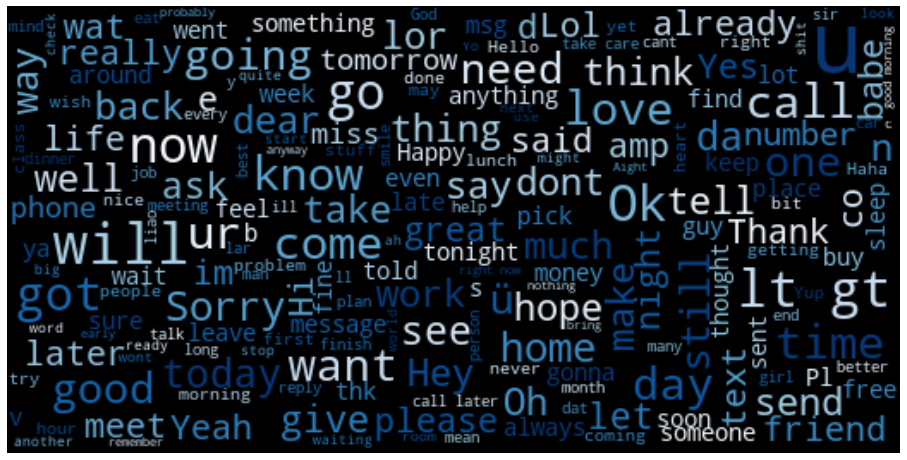

In [149]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

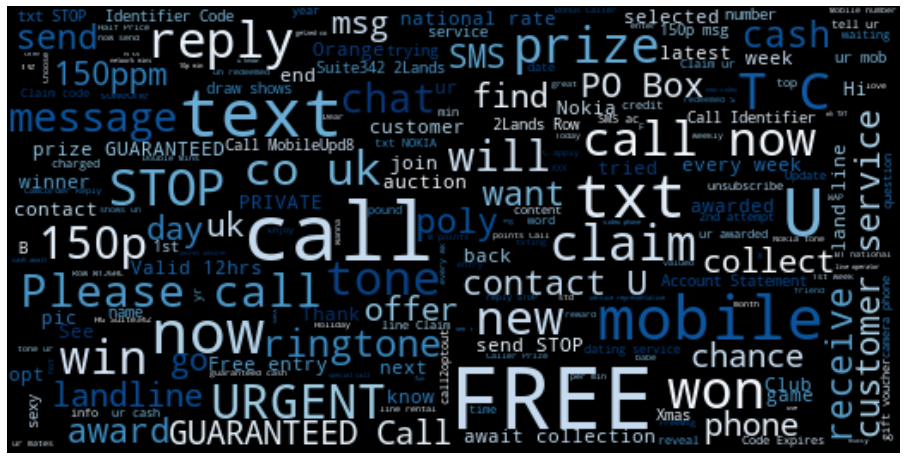

In [150]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


15.481865284974095

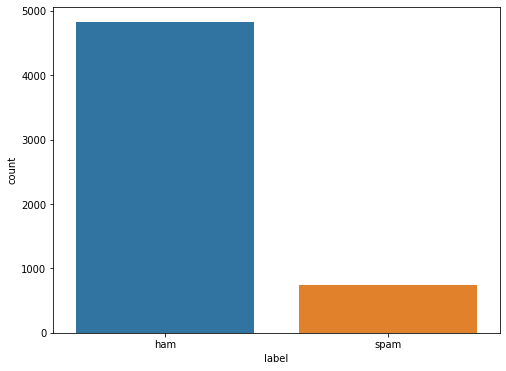

In [151]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

In [152]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

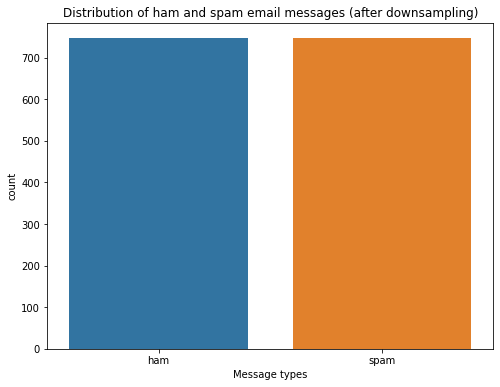

In [153]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [154]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,73.238286
spam,138.670683


In [155]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [156]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [157]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [158]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [159]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)


There are 4169 unique tokens in training data. 


In [160]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [161]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)


Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [162]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [163]:
print(training_padded[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


 #                          **Dense Hidden Layer**








In [164]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [165]:
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [166]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 24)                408       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

In [167]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [168]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6843 - accuracy: 0.7598 - val_loss: 0.6748 - val_accuracy: 0.7926 - 960ms/epoch - 25ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6549 - accuracy: 0.8510 - val_loss: 0.6327 - val_accuracy: 0.8294 - 109ms/epoch - 3ms/step
Epoch 3/30
38/38 - 0s - loss: 0.5922 - accuracy: 0.8711 - val_loss: 0.5572 - val_accuracy: 0.8462 - 111ms/epoch - 3ms/step
Epoch 4/30
38/38 - 0s - loss: 0.4998 - accuracy: 0.8787 - val_loss: 0.4642 - val_accuracy: 0.8528 - 108ms/epoch - 3ms/step
Epoch 5/30
38/38 - 0s - loss: 0.3993 - accuracy: 0.8987 - val_loss: 0.3790 - val_accuracy: 0.8662 - 127ms/epoch - 3ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3161 - accuracy: 0.9079 - val_loss: 0.3139 - val_accuracy: 0.8896 - 112ms/epoch - 3ms/step
Epoch 7/30
38/38 - 0s - loss: 0.2566 - accuracy: 0.9163 - val_loss: 0.2679 - val_accuracy: 0.8930 - 104ms/epoch - 3ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2141 - accuracy: 0.9389 - val_loss: 0.2255 - val_accuracy: 0.9064 - 119ms/epoch - 3ms/step
Epoch 9/30
38/3

In [169]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9365


[0.12617890536785126, 0.9364548325538635]

In [170]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

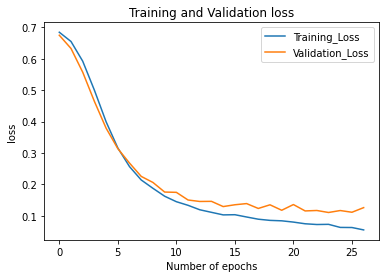

In [171]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

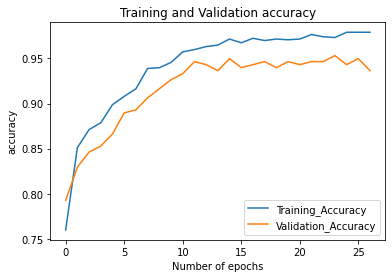

In [172]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

#               **Long Short Term Memory (LSTM) Model**

In [173]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

In [174]:
#LSTM Spam detection architecture
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

In [175]:
messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [176]:
messages.describe().T

,count,unique,top,freq
label,5572,2,ham,4825
message,5572,5169,"Sorry, I'll call later",30


In [177]:
messages.shape

(5572, 2)

In [178]:
messages.isnull().sum()

label      0
message    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


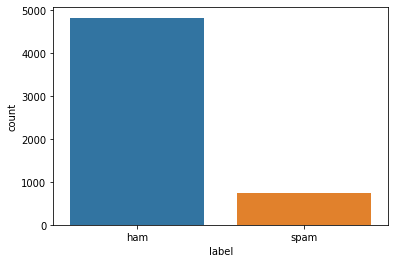

In [179]:
sns.countplot(messages.label)

In [180]:
X = messages.message
Y = messages.label
le = LabelEncoder()
Y = le.fit_transform(Y)

In [181]:
Y = Y.reshape(-1,1)

In [182]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)

In [183]:
max_word = 1000
max_len = 250
token = Tokenizer(num_words = max_word)
token.fit_on_texts(X_train)
sequences = token.texts_to_sequences(X_train)
seq_matrix = pad_sequences(sequences , maxlen = max_len)

In [184]:
model = Sequential()
model.add(Embedding(max_word , 32 , input_length = max_len))
model.add(LSTM(64))
model.add(Flatten())

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(120, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [185]:
# Compile the model
model.compile(loss = 'binary_crossentropy' , optimizer = 'RMSprop' , metrics = 'accuracy')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 250, 32)           32000     
                                                                 
 lstm_13 (LSTM)              (None, 64)                24832     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 250)               16250     
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_18 (Dense)            (None, 120)               30120     
                                                                 
 dense_19 (Dense)            (None, 1)               

In [186]:
history = model.fit(seq_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
28/28 [==============================] - 15s 421ms/step - loss: 0.3305 - accuracy: 0.8732 - val_loss: 0.1674 - val_accuracy: 0.9765
Epoch 2/10
28/28 [==============================] - 11s 398ms/step - loss: 0.0754 - accuracy: 0.9818 - val_loss: 0.0521 - val_accuracy: 0.9832


In [187]:
test_seq = token.texts_to_sequences(X_test)
test_seq_matrix = pad_sequences(test_seq,maxlen=max_len)

In [188]:
scores = model.evaluate(test_seq_matrix, Y_test, verbose=0)
scores

[0.05998490750789642, 0.9838564991950989]

In [189]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 98.39%
